# Install, import and initialize
First, we shall import basic libraries for handling dataset and training the model

In [49]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

# Import W&B and login
Login the Weights & bias service with the given token

In [50]:
import wandb
from wandb.keras import WandbCallback

project_name = 'project-fashion-mnist'
# %env WANDB_API_KEY='1af04e33e3d441eb82eb612e2c001eddec29bccb'

wandb.login(relogin=True)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Avni Eshchar/.netrc


True

# Download and prepare the dataset
First we download the dataset, then we enrich it by adding an augmented version to it. Lastly, we normalize to the 0-1 range

In [51]:
import albumentations as A
from class_names import class_names
import cv2

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

transform = A.Compose([
    # A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-15, 15), border_mode=cv2.BORDER_CONSTANT)
])

X_train_augmented = np.copy(x_train)
y_train_augmented = np.copy(y_train)

for i, image in enumerate(X_train_augmented ):
    X_train_augmented[i] = transform(image=image)['image']
    
x_train, y_train = np.concatenate([x_train, X_train_augmented]), np.concatenate([y_train, y_train_augmented])

# Subsetting train data and normalizing to [0., 1.]
x_train, x_test = x_train / 255., x_test / 255.
input_shape = (28, 28, 1)
num_classes = len(class_names)

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (120000, 28, 28)
Shape of y_train:  (120000,)
Shape of x_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


### Regular fashion dataset

Original dataset samples:


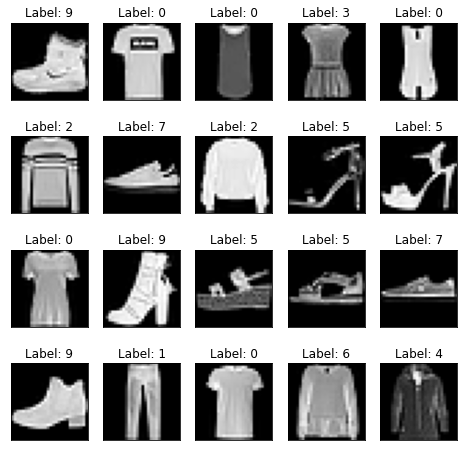

In [68]:
print('Original dataset samples:')
fig = plt.figure(figsize=(8, 8))
fig.clear()
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train_augmented[i]}")

### Augmented dataset

Augmented dataset samples:


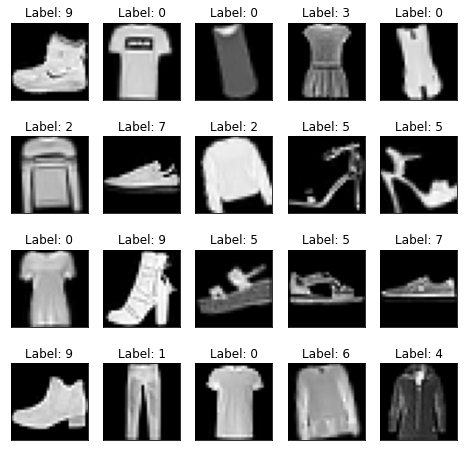

In [67]:
print('Augmented dataset samples:')
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(X_train_augmented[i], cmap="gray")
    ax.set_title(f"Label: {y_train_augmented[i]}")

# Define a model

Here, we define a standard CNN (with convolution and max-pooling) in Keras.

In [54]:
def Model():
    inputs = keras.layers.Input(shape=input_shape)

    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(inputs)
    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(28, activation='relu')(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, )

# Train the model

In [55]:
# Initialize wandb with your project name
run = wandb.init(project=project_name,
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "fashion_mnist"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 28)        7084      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 28)          7084      
                                                             

In [56]:
# We focus on a subset of images, since this is for human review
val_images, val_labels = x_test[:32], y_test[:32]

_ = model.fit(x_train, y_train,
              epochs=config.epochs, 
              batch_size=config.batch_size,
              validation_data=(x_test, y_test),
              callbacks=[WandbCallback(data_type='image', 
                                       validation_data=(val_images, val_labels), 
                                       labels=class_names)])

run.finish()

Epoch 1/5
2/2 [==============================] - 0s 4ms/step0s - loss: 0.7264 - acc: 0.72


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 107s 28ms/step - loss: 0.7263 - acc: 0.7233 - val_loss: 0.5002 - val_acc: 0.8137
Epoch 2/5
2/2 [==============================] - 0s 3ms/step0s - loss: 0.4441 - acc: 0.83


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 107s 28ms/step - loss: 0.4441 - acc: 0.8344 - val_loss: 0.3864 - val_acc: 0.8599
Epoch 3/5
2/2 [==============================] - 0s 4ms/step0s - loss: 0.3590 - acc: 0.86


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 106s 28ms/step - loss: 0.3590 - acc: 0.8678 - val_loss: 0.3285 - val_acc: 0.8856
Epoch 4/5
3750/3750 [==============================] - 101s 27ms/step - loss: 0.3163 - acc: 0.8851 - val_loss: 0.3585 - val_acc: 0.8743
Epoch 5/5
2/2 [==============================] - 0s 3ms/step0s - loss: 0.2887 - acc: 0.89


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230118_070637-rx3eilt4\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 102s 27ms/step - loss: 0.2888 - acc: 0.8946 - val_loss: 0.2917 - val_acc: 0.8960


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▃▂▁▁
val_acc,▁▅▇▆█
val_loss,█▄▂▃▁
acc,0.89458
best_epoch,4
best_val_loss,0.29165
epoch,4
loss,0.28876
val_acc,0.896


## Hyperparameters search
At start, there was an attempt to use W&B swip for hyper search, but it failed every time, probably of configurations issues.

So, I investigated for the most recommended tuners, and came up with keras-tuner as one of them.

Model is declared in a model_builder function amongst with hyper parameters to tweek on.

In [57]:
import keras_tuner as kt
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.losses import SparseCategoricalCrossentropy


def conv_pool_layer(filters, kernel_size, strides, pool_size):
    return keras.Sequential([
        Conv2D(filters=filters, kernel_size=kernel_size,
               strides=strides, activation='relu', padding="SAME"),
        Conv2D(filters=filters, kernel_size=kernel_size,
               strides=strides, activation='relu', padding="SAME"),
        MaxPooling2D(pool_size=pool_size, padding="SAME"),
    ], name=f"conv-pool-{filters}-{kernel_size}")


def model_builder(hp):
    hp_conv_units = hp.Int('hp_conv_units', min_value=16, max_value=32, step=4)
    hp_kernel = hp.Int('hp_kernel', min_value=2, max_value=5, step=1)
    hp_strides = hp.Int('hp_strides', min_value=1, max_value=4)
    hp_dropout = hp.Float('hp_dropout', min_value=0.2, max_value=0.8, sampling='log')
    hp_pool_size = hp.Int('hp_pool_size', min_value=2, max_value=4)
    hp_dense_units = hp.Int(
        'hp_dense_units', min_value=256, max_value=2000, step=500)
    hp_learning_rate = hp.Float(
        'learning_rate', min_value=0.001, max_value=0.1, sampling='log')
    ht_activation = hp.Choice('activation', ['relu', 'tanh', 'leaky_relu'])

    model = keras.Sequential([
        Input(shape=input_shape, name='input'),

        conv_pool_layer(hp_conv_units, hp_kernel, hp_strides, hp_pool_size),
        conv_pool_layer(hp_conv_units*2, hp_kernel, hp_strides, hp_pool_size),
        conv_pool_layer(hp_conv_units*4, hp_kernel, hp_strides, hp_pool_size),

        Dropout(hp_dropout, name='dropout'),
        Flatten(name='flatten'),

        Dense(units=hp_dense_units, activation=ht_activation, name='dense-1'),
        Dense(units=num_classes*3, activation=ht_activation, name='dense-2'),

        Dense(units=num_classes, activation='softmax', name='prediction')
    ], name='le_chen_net')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = model_builder(kt.HyperParameters())
model.summary()


Model: "le_chen_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-pool-16-2 (Sequential)  (None, 14, 14, 16)       1120      
                                                                 
 conv-pool-32-2 (Sequential)  (None, 7, 7, 32)         6208      
                                                                 
 conv-pool-64-2 (Sequential)  (None, 4, 4, 64)         24704     
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense-1 (Dense)             (None, 256)               262400    
                                                                 
 dense-2 (Dense)             (None, 30)                

## Perform a Hyper parameters search
In the beginning, I used the whole dataset for hyper searching params. That took quite a long time (about 30+ hours for 1 cycle).

I realized that in ML, it is always a question of available time and computer resources, which (in my case) I had neither.

Actually, in hyper search, I only need to reach the best parameters' set, not to have the most trained model (which should come later).

Working with only a small equaly-distributed portion of the dataset in which the data was able to converge, could lead to the same results faster.

In [58]:
def get_weighted_subset(x_train, y_train, frac=0.25, train_val_split=0.2):
    num_records = len(y_train)
    df = pd.DataFrame({ 'target': y_train })
    df = df.groupby('target').apply(lambda x: x.sample(frac=frac))
    df = df.droplevel('target')
    index = df.index
    X_sampled, y_sampled = x_train[index], y_train[index]
    p = np.arange(len(y_sampled))
    np.random.shuffle(p)
    X_sampled = X_sampled[p]
    y_sampled = y_sampled[p]
    print(f'Total dataset records: {len(y_train)}')
    print(f'Number of samples for Hyper-search: {len(y_sampled)} ({len(y_sampled) / num_records * 100}%)')

    num_val_records = int(len(y_sampled) * train_val_split)
    X_val_sampled, y_val_sampled = X_sampled[0:num_val_records], y_sampled[0:num_val_records]
    X_sampled = X_sampled[num_val_records:]
    y_sampled = y_sampled[num_val_records:]
    
    print(f'Validation split: {num_val_records} ({num_val_records / (num_val_records + len(X_sampled)) * 100}% of samples)')
    return X_sampled, y_sampled, X_val_sampled, y_val_sampled

X_sampled, y_sampled, X_val_sampled, y_val_sampled = get_weighted_subset(x_train, y_train, frac=0.3, train_val_split=0.2)


Total dataset records: 120000
Number of samples for Hyper-search: 36000 (30.0%)
Validation split: 7200 (20.0% of samples)


In [59]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=30,
    directory='hp_search',
    overwrite=True,
    project_name='predict_fashion_item-1')

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
mc = ModelCheckpoint('./fashion_mnist.hd5', monitor='val_accuracy', verbose=1)

tuner.search(X_sampled, y_sampled, validation_data=(X_val_sampled, y_val_sampled), epochs=10, callbacks=[es, mc])

# Get the optimal model with best params
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

Trial 90 Complete [00h 01m 43s]
val_accuracy: 0.6920833587646484

Best val_accuracy So Far: 0.9012500047683716
Total elapsed time: 02h 50m 13s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in hp_search\predict_fashion_item-1
Showing 10 best trials
Trial summary
Hyperparameters:
hp_conv_units: 24
hp_kernel: 3
hp_strides: 1
hp_dropout: 0.21231268126239888
hp_pool_size: 2
hp_dense_units: 1756
learning_rate: 0.0019808022929698856
activation: leaky_relu
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 0.9012500047683716
Trial summary
Hyperparameters:
hp_conv_units: 24
hp_kernel: 3
hp_strides: 1
hp_dropout: 0.21231268126239888
hp_pool_size: 2
hp_dense_units: 1756
learning_rate: 0.0019808022929698856
activation: leaky_relu
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0058
Score: 0.8931944370269775
Trial summary
Hyperparameters:
hp_conv_units: 24
hp_kernel: 3
hp_strides: 1
hp_dropout: 0.21231268126239888
hp_pool_size: 2
hp_dense_units: 1756
learning_rate: 0.0019808022929698856
activation: leaky_relu
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/r

# Fit model based on best params

In [60]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
3000/3000 [==============================] - 224s 74ms/step - loss: 0.4538 - accuracy: 0.8318 - val_loss: 0.3725 - val_accuracy: 0.8613
Epoch 2/50
3000/3000 [==============================] - 223s 74ms/step - loss: 0.3153 - accuracy: 0.8834 - val_loss: 0.3196 - val_accuracy: 0.8826
Epoch 3/50
3000/3000 [==============================] - 223s 74ms/step - loss: 0.2855 - accuracy: 0.8951 - val_loss: 0.3192 - val_accuracy: 0.8816
Epoch 4/50
3000/3000 [==============================] - 223s 74ms/step - loss: 0.2672 - accuracy: 0.9020 - val_loss: 0.3035 - val_accuracy: 0.8894
Epoch 5/50
3000/3000 [==============================] - 223s 74ms/step - loss: 0.2572 - accuracy: 0.9055 - val_loss: 0.2900 - val_accuracy: 0.8923
Epoch 6/50
3000/3000 [==============================] - 223s 74ms/step - loss: 0.2441 - accuracy: 0.9107 - val_loss: 0.2913 - val_accuracy: 0.8958
Epoch 7/50
3000/3000 [==============================] - 224s 75ms/step - loss: 0.2424 - accuracy: 0.9114 - val_loss: 0

# Evaluate model

In [63]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 6s 71ms/step - loss: 0.2999 - accuracy: 0.9001
test loss, test acc: [0.29993507266044617, 0.9000999927520752]


# Save Trained Best Model

In [64]:
model.save('./fashion_mnist.hd5')

INFO:tensorflow:Assets written to: ./fashion_mnist.hd5\assets


INFO:tensorflow:Assets written to: ./fashion_mnist.hd5\assets
